Загрузка видео и формирование обучающей выборки для видео с канала Sky Guitar

# Загрузка библиотек

In [1]:
import os
from pathlib import Path
from pytube import YouTube
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import hashlib
import imagehash
from tqdm import tqdm
from PIL import ImageOps
import numpy as np
import pandas as pd
import shutil

# Загрузка видео

In [2]:
url = 'https://www.youtube.com/watch?v=rq3bZzLhyOM'
filename_video = 'skyguitar_sample.mp4'
yt = YouTube(url)
video_path = Path('videos')
if not os.path.exists: os.makedirs(video_path)
# progressive - True (delete)
yt.streams.filter(progressive=True, file_extension='mp4').order_by(
        'resolution').desc().first().download(output_path=video_path, filename=filename_video)

'c:\\projects\\note_stealer\\note_stealer\\videos\\skyguitar_sample.mp4'

# Покадровое считывание видео и запись в файл

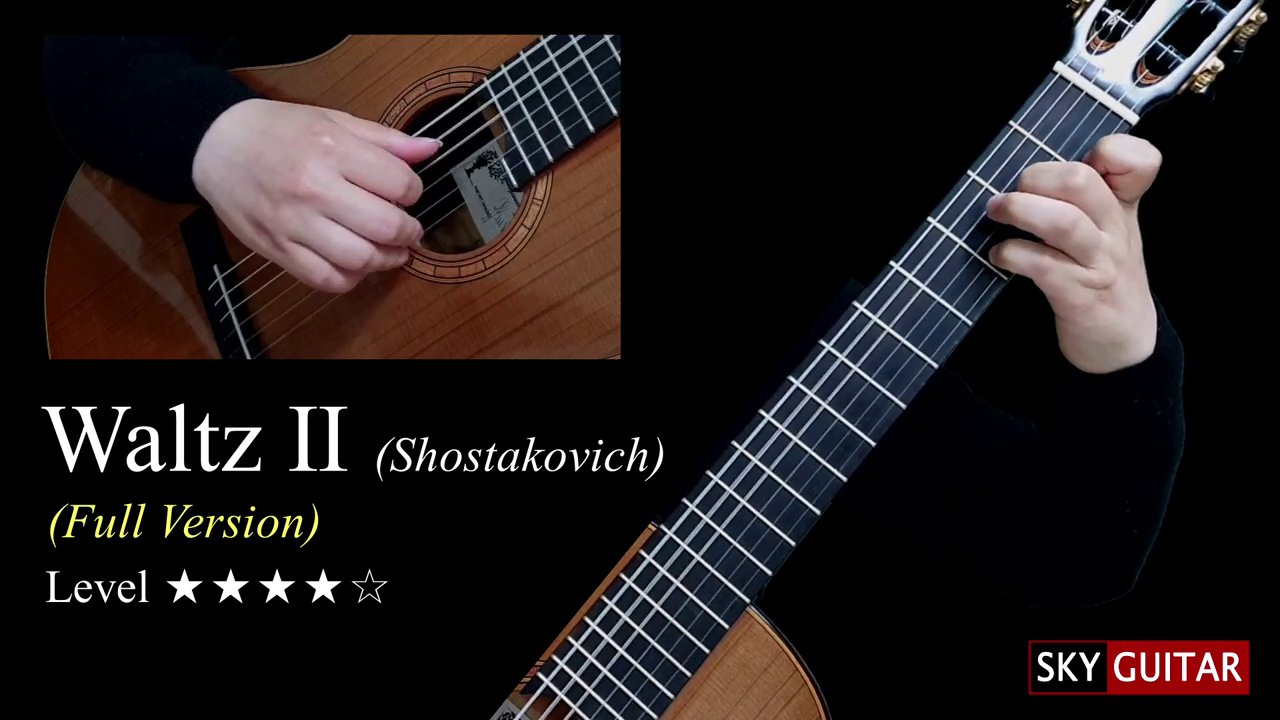

In [3]:
i = 0
cap = cv2.VideoCapture((video_path / filename_video).__str__())   # /dev/video0
while i<500:
  ret, frame = cap.read()
  if not ret:
    break
  pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
  i+=1
pil_img

In [5]:
path_images = Path('images/skyguitar')
if not os.path.exists(path_images): os.makedirs(path_images)
vidcap = cv2.VideoCapture(str(video_path / filename_video))
success,image = vidcap.read()
count = 0
while success:
    cv2.imwrite(str(path_images / ("skyguitar_frame%d.jpg" % count)), image)     # save frame as JPEG file      
    success, image = vidcap.read()
    count += 1

# Определение координат для видео формата SkyGuitar


In [6]:
notes_start_frame = 8196
notes_end_frame = 18123

In [7]:
# reading the image 
img = cv2.imread(str(path_images / f'skyguitar_frame{notes_start_frame}.jpg'), 1) 

# function to display the coordinates of 
# of the points clicked on the image  
def click_event(event, x, y, flags, params): 
    # checking for left mouse clicks 
    if event == cv2.EVENT_LBUTTONDOWN: 
        # displaying the coordinates 
        # on the Shell 
        print(x, ' ', y) 
        # displaying the coordinates 
        # on the image window 
        font = cv2.FONT_HERSHEY_SIMPLEX 
        cv2.putText(img, str(x) + ',' +
                    str(y), (x,y), font, 
                    1, (255, 0, 0), 2) 
        cv2.imshow('image', img) 
    # checking for right mouse clicks      
    if event==cv2.EVENT_RBUTTONDOWN: 
        # displaying the coordinates 
        # on the Shell 
        print(x, ' ', y) 
        # displaying the coordinates 
        # on the image window 
        font = cv2.FONT_HERSHEY_SIMPLEX 
        b = img[y, x, 0] 
        g = img[y, x, 1] 
        r = img[y, x, 2] 
        cv2.putText(img, str(b) + ',' +
                    str(g) + ',' + str(r), 
                    (x,y), font, 1, 
                    (255, 255, 0), 2) 
        cv2.imshow('image', img) 


# displaying the image 
cv2.imshow('image', img) 
# setting mouse handler for the image 
# and calling the click_event() function 
cv2.setMouseCallback('image', click_event) 
# wait for a key to be pressed to exit 
cv2.waitKey(0) 
# close the window 
cv2.destroyAllWindows() 

(x1, y1) - (0, 395)<br>
(x2, y2) - (1280, 720)

In [8]:
x1, y1, x2, y2 = 0, 395, 1280, 720

# Определение порога для отсечения дубликатов

In [12]:
first_frame25 = 9908
last_frame25 = 10311
first_frame31 = 10312
last_frame31 = 10717

In [15]:
frames = [first_frame25, last_frame25, first_frame31, last_frame31]
filenames = [str(path_images / f'skyguitar_frame{i}.jpg') for i in range(first_frame25, last_frame31+1)]
df_hash = pd.DataFrame({
    'filename': filenames
})

In [16]:
# hash_size = 8
def phash(image: Image.Image, hash_size: int=8) -> str:
    return str(
        hashlib.sha256(
            bytearray(
                imagehash.phash(
                    image, hash_size=hash_size
                ).hash.flatten().astype(int).tolist())
            ).hexdigest())

filename = df_hash['filename'][0]
img = Image.open(filename).crop((x1, y1, x2, y2))

nuniques = []
for i in tqdm(range(2, 17)):
    phashes = []
    for filename in df_hash['filename']:
        img = Image.open(filename).crop((x1, y1, x2, y2))
        img = ImageOps.grayscale(img)
        phashes.append(phash(img, i))
    df_hash['hash'] = phashes
    nuniques.append(df_hash['hash'].nunique())

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:54<00:00,  3.62s/it]


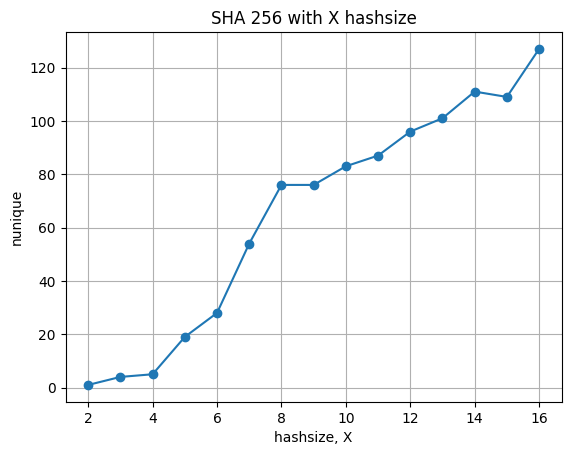

In [17]:
plt.plot(range(2, 17), nuniques, '-o')
plt.grid()
plt.ylabel('nunique')
plt.xlabel('hashsize, X')
plt.title('SHA 256 with X hashsize')
plt.show()

In [18]:
nuniques

[1, 4, 5, 19, 28, 54, 76, 76, 83, 87, 96, 101, 111, 109, 127]

In [19]:
i = 3 
phashes = []
for filename in df_hash['filename']:
    img = Image.open(filename).crop((x1, y1, x2, y2))
    img = ImageOps.grayscale(img)
    phashes.append(phash(img, i))
df_hash['hash'] = phashes

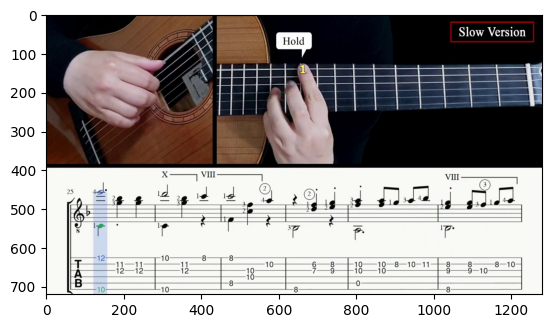

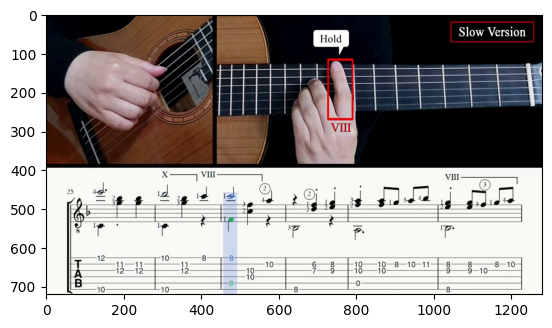

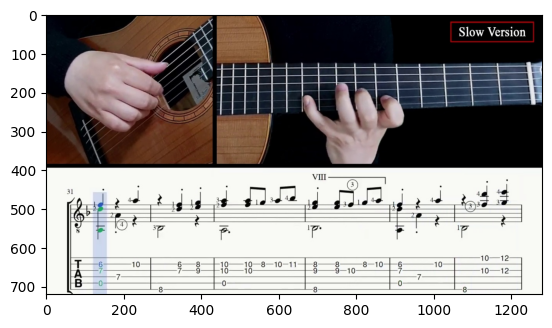

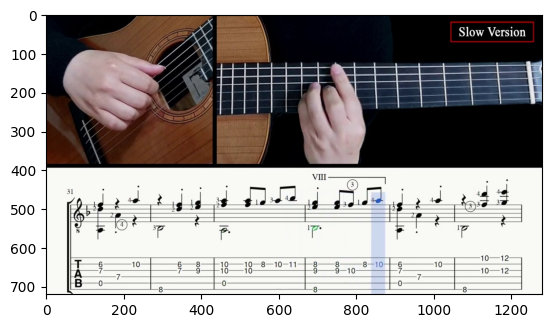

In [20]:
for filen in df_hash.drop_duplicates(subset='hash')['filename']:
    img = Image.open(filen)
    plt.imshow(img)
    plt.show()

Экспертный порог - хэш 4. При 3 отбрасывается большая часть скринов

# Формирирование обучающей выборки

In [21]:
path_yolo_data = Path('yolo_data')
if not os.path.exists(path_yolo_data): os.makedirs(path_yolo_data)
path_skyguitar_data = path_yolo_data / 'skyguitar'
if not os.path.exists(path_skyguitar_data): os.makedirs(path_skyguitar_data)
path_skyguitar_images = path_skyguitar_data / 'images'
if not os.path.exists(path_skyguitar_images): os.makedirs(path_skyguitar_images)
path_skyguitar_labels = path_skyguitar_data / 'labels'
if not os.path.exists(path_skyguitar_labels): os.makedirs(path_skyguitar_labels)

In [22]:
def open_img(filename):
    img = Image.open(filename).crop((x1, y1, x2, y2))
    img = ImageOps.grayscale(img)
    return img

In [23]:
filenames = [str(path_images / x) for x in os.listdir(path_images)]
df_hash = pd.DataFrame({'filename': filenames})
hash_f = lambda x: phash(open_img(x), 4)
vect_hash_f = np.vectorize(hash_f)
hashes = vect_hash_f(df_hash['filename'])
df_hash['hash'] = hashes

In [25]:
df_nodupl = df_hash.drop_duplicates('hash', keep='first')
df_nodupl['index'] = df_nodupl['filename'].apply(
    lambda x: x.split('.')[0].replace(r'images\skyguitar\skyguitar_frame', '')).astype(int)
df_nodupl.sort_values(by='index', inplace=True)

C:\Users\Dm\AppData\Local\Temp\ipykernel_11036\3840055639.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodupl['index'] = df_nodupl['filename'].apply(
C:\Users\Dm\AppData\Local\Temp\ipykernel_11036\3840055639.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nodupl.sort_values(by='index', inplace=True)


In [26]:
# ноты
df_notes = df_nodupl.loc[
    (df_nodupl['index']>=notes_start_frame) &
    (df_nodupl['index']<=notes_end_frame)
]
df_notes.shape

(91, 3)

In [27]:
df_notes['short_filename'] = df_notes['filename'].apply(lambda x: x.split("\\")[-1].replace('.jpg', ''))

C:\Users\Dm\AppData\Local\Temp\ipykernel_11036\2808070775.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_notes['short_filename'] = df_notes['filename'].apply(lambda x: x.split("\\")[-1].replace('.jpg', ''))


In [28]:
img = Image.open(df_notes['filename'].iloc[0])
w, h = img.size

In [29]:
x_yolo = ((x2+x1) / 2) / w
y_yolo = ((y2+y1) / 2) / h
w_yolo = (x2-x1) / w
h_yolo = (y2-y1) / h

In [30]:
str_yolo = ' '.join([str(x) for x in [0, x_yolo, y_yolo, w_yolo, h_yolo]])

In [31]:
for row in tqdm(df_notes.iterrows()):
    row = row[1]
    filename = row['filename']
    short_filename = row['short_filename']
    shutil.copy(filename, path_skyguitar_images)
    with open(path_skyguitar_labels / (short_filename + '.txt'), 'w') as file:
        file.write(str_yolo)

91it [00:00, 1212.67it/s]


In [32]:
# антиклассы
df_hash['index'] = df_hash['filename'].apply(
    lambda x: x.split('.')[0].replace(r'images\skyguitar\skyguitar_frame', '')).astype(int)
df_hash.sort_values(by='index', inplace=True)

In [33]:
df_hash['short_filename'] = df_hash['filename'].apply(lambda x: x.split('\\')[-1].split('.')[0])

In [34]:
for row in df_hash.loc[df_hash['index']<notes_start_frame].iterrows():
    row = row[1]
    filename = row['filename']
    short_filename = row['short_filename']
    shutil.copy(row['filename'], path_skyguitar_images)
    with open(path_skyguitar_labels / (short_filename + '.txt'), 'w') as file:
        file.write('')